In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from umap import UMAP
import umap.plot
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

from pycaret.classification import setup, compare_models, evaluate_model, plot_model
import optuna

C:\Users\Anes3\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_excel('Data_Train.xlsx')
test = pd.read_excel('Data_Test.xlsx')
target = train.SECTION
train = train.drop('SECTION', axis=1).copy()
train.shape

(7628, 1)

In [3]:
train.head()

,STORY
0,But the most painful was the huge reversal in ...
1,How formidable is the opposition alliance amon...
2,Most Asian currencies were trading lower today...
3,"If you want to answer any question, click on ‘..."
4,"In global markets, gold prices edged up today ..."


In [4]:
target.value_counts()

1.0    2772
2.0    1924
0.0    1686
3.0    1246
Name: SECTION, dtype: int64

In [5]:
train0 = pd.concat([train, test])

# Feature Transformation

In [6]:
vectorizer = TfidfVectorizer()
vectorizer.fit(train0['STORY'])
train1 = vectorizer.transform(train0['STORY'])

In [7]:
train1.shape

(10376, 37165)

# UMAP

In [8]:
mapper = UMAP(n_components=2).fit(X_train)
X = mapper.transform(X_train)
umap.plot.points(mapper, labels=target)

# Base Model

In [9]:
mapper = UMAP(n_components=10, n_neighbors=30).fit(train1)
train2 = mapper.transform(train1)

In [10]:
train3 = pd.DataFrame(train2)

In [43]:
X_train = train3.iloc[:len(train), :]
X_test = train3.iloc[len(train):, :]

In [20]:
model = RandomForestClassifier(random_state=0)

results=[]

kf = KFold(n_splits=5)
r = cross_val_score(model, X_train, target, scoring='accuracy', cv=kf)
results.append(r)
print(f'Accuracy: {round(np.mean(results), 2)}')

Accuracy: 0.96


In [21]:
_ = setup(data=pd.concat([X_train, target], axis=1), target='SECTION')

,Description,Value
0,session_id,6542
1,Target,SECTION
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(7628, 11)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [22]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9506,0.9938,0.9486,0.9509,0.9506,0.9320,0.9321,0.1790
lightgbm,Light Gradient Boosting Machine,0.9496,0.9935,0.9471,0.9499,0.9496,0.9307,0.9308,0.1290
rf,Random Forest Classifier,0.9492,0.9931,0.9474,0.9496,0.9493,0.9302,0.9303,0.2420
knn,K Neighbors Classifier,0.9483,0.9844,0.9459,0.9488,0.9483,0.9289,0.9290,0.0560
gbc,Gradient Boosting Classifier,0.9483,0.9916,0.9468,0.9488,0.9483,0.9289,0.9291,0.8760
qda,Quadratic Discriminant Analysis,0.9406,0.9853,0.9423,0.9415,0.9407,0.9186,0.9188,0.0050
ridge,Ridge Classifier,0.9403,0.0000,0.9376,0.9411,0.9403,0.9178,0.9180,0.0040
nb,Naive Bayes,0.9401,0.9820,0.9427,0.9414,0.9402,0.9179,0.9182,0.0040
lda,Linear Discriminant Analysis,0.9399,0.9865,0.9403,0.9409,0.9400,0.9175,0.9178,0.0050
svm,SVM - Linear Kernel,0.9329,0.0000,0.9318,0.9367,0.9333,0.9079,0.9090,0.0270


In [23]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

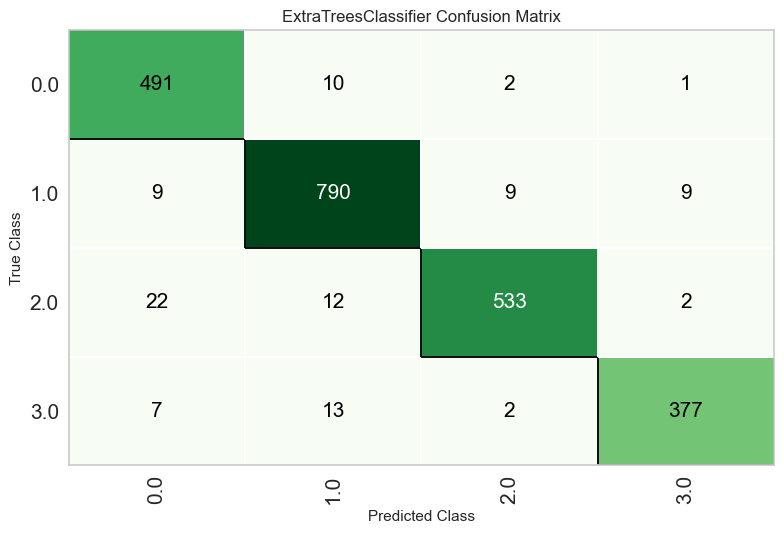

In [24]:
plot_model(best, plot = 'confusion_matrix')

# Hyperparameters

In [25]:
def et(trial):
    max_depth = trial.suggest_int('max_depth', 1, 100)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 100)
          
    model = ExtraTreesClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes
    )
    
    model.fit(X, target)
    
    cv_scores = cross_val_score(model, X, target, scoring='accuracy', cv=kf)
    
    return np.mean(cv_scores)

In [26]:
def rf(trial):
    max_depth = trial.suggest_int('max_depth', 1, 100)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 100)
          
    model = RandomForestClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes
    )
    
    model.fit(X, target)
    
    cv_scores = cross_val_score(model, X, target, scoring='accuracy', cv=kf)
    
    return np.mean(cv_scores)

In [27]:
def lightgbm(trial):
    num_leaves  = trial.suggest_int('num_leaves', 5, 100)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    learning_rate = trial.suggest_loguniform('learning_rate', .001, 1)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 100)
          
    model = LGBMClassifier(
        num_leaves=num_leaves ,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        min_child_samples=min_child_samples
    )
    
    model.fit(X, target)
    
    cv_scores = cross_val_score(model, X, target, scoring='accuracy', cv=kf)
    
    return np.mean(cv_scores)

In [28]:
def knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 2, 100)
          
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors
    )
    
    model.fit(X, target)
    
    cv_scores = cross_val_score(model, X, target, scoring='accuracy', cv=kf)
    
    return np.mean(cv_scores)

In [29]:
def gbc(trial):
    max_depth = trial.suggest_int('max_depth', 1, 50)
    learning_rate = trial.suggest_loguniform('learning_rate', .001, 1)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 100)
          
    model = GradientBoostingClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes
    )
    
    model.fit(X, target)
    
    cv_scores = cross_val_score(model, X, target, scoring='accuracy', cv=kf)
    
    return np.mean(cv_scores)

In [30]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(et, n_trials=100)
# study.best_params

In [31]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(rf, n_trials=100)
# study.best_params

In [32]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(lightgbm, n_trials=100)
# study.best_params

In [33]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(knn, n_trials=100)
# study.best_params

In [34]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(gbc, n_trials=100)
# study.best_params

In [35]:
et_params = {
    'max_depth': 55,
    'n_estimators': 490,
    'min_samples_leaf': 1,
    'max_leaf_nodes': 85
}

rf_params = {
    'max_depth': 13,
    'n_estimators': 334,
    'min_samples_leaf': 1,
    'max_leaf_nodes': 85
}

lightgbm_params = {
    'num_leaves': 45,
    'max_depth': 27,
    'learning_rate': 0.014835718733748062,
    'n_estimators': 431,
    'min_child_samples': 70
}

knn_params = {'n_neighbors': 5}

gbc_params = {
    'max_depth': 21,
    'learning_rate': 0.04164140857939236,
    'n_estimators': 381,
    'min_samples_leaf': 37,
    'max_leaf_nodes': 60
}

In [36]:
et_model = ExtraTreesClassifier(**et_params, verbose=0)
lightgbm_model = LGBMClassifier(**lightgbm_params, verbose=-1, force_col_wise=True)
rf_model = RandomForestClassifier(**rf_params, verbose=0)
knn_model =  KNeighborsClassifier(**knn_params)
gbc_model = GradientBoostingClassifier(**gbc_params, verbose=0)

In [37]:
final_model = VotingClassifier(estimators=[('et', et_model), 
                                           ('lightgbm', lightgbm_model), 
                                           ('rf', rf_model),
                                           ('knn', knn_model),
                                           ('gbc', gbc_model)], 
                               voting='soft')

In [38]:
results_ensemble = []

r_ensemble = cross_val_score(final_model, X_train, target, scoring='accuracy')
results_ensemble.append(r_ensemble)
print(f'Accuracy: {np.mean(results_ensemble).round(2)}')

Accuracy: 0.95


In [39]:
final_model.fit(X_train, target)

VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=55,
                                                   max_features='auto',
                                                   max_leaf_nodes=85,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                     

In [44]:
final_predictions = final_model.predict(X_test)

submission = pd.concat([pd.Series(final_predictions, name='SECTION')], axis=1)
submission

,SECTION
0,1.0
1,2.0
2,1.0
3,0.0
4,1.0
...,...
2743,1.0
2744,1.0
2745,1.0
2746,0.0


In [45]:
submission.to_csv('submission_ensemble_model.csv', index=False)#, header=True)